# ECSE 415 - Assignment 4:  Neural Networks
## Theo Ghanem 260972584

Note that parts of this assignment have been taken/inspired from the following sources:
- Tutorials
- PyTorch documentation
- StackOverflow
- Generative AI
- Class lectures

## Part 1 - CIFAR-10 Classification using Convolution Neural Network

In [ ]:
import torch
from torch import nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

Check the version of PyTorch and CUDA to make sure my laptop's GPU is detected properly

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print("-----------------------------")
print(torch.version.cuda)
print(f'PyTorch version: {torch.__version__}')
print('*'*10)
print(f'_CUDA version: ')
print('*'*10)
print(f'Available GPU devices: {torch.cuda.device_count()}')
print(f'Device Name: {torch.cuda.get_device_name()}')

cuda:0
-----------------------------
12.1
PyTorch version: 2.2.1+cu121
**********
_CUDA version: 
**********
Available GPU devices: 1
Device Name: NVIDIA GeForce RTX 3050 Ti Laptop GPU


### 1. Implement a shallow CNN with the layers mentioned below.
### 2. Use Pytorch Class torchvision.datasets.CIFAR10 to load the dataset.
### 3. Training, validation and test settings are shown below.

In [ ]:
from torch.utils.data import Subset

# Define constants
NUM_CLASSES = 10  # Number of classes in CIFAR-10
BATCH_SIZE = 32  # Batch size for training
LEARNING_RATE = 0.002  # Initial learning rate
NUM_EPOCHS = 30  # Number of epochs for training (you can adjust this)

# Define the size of the subset you want to take
subset_size = 20000  # Adjust this value as needed

# Define data transforms
transform = transforms.Compose([
  transforms.ToTensor(),  # Convert image to tensor
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize data
])

# Load the CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Generate a list of indices from 0 to subset_size
indices = list(range(subset_size))

# Create the subset
subset_train_dataset = Subset(train_dataset, indices)
#
# Split the test set into validation and test sets
validation_size = 5000
test_size = len(test_dataset) - validation_size

val_dataset, _ = torch.utils.data.random_split(train_dataset, [validation_size, len(train_dataset) - validation_size])
test_dataset = torch.utils.data.Subset(test_dataset, indices=range(test_size))

# Create data loaders
# train_loader = torch.utils.data.DataLoader(subset_train_dataset, batch_size=BATCH_SIZE, shuffle=True) # if I want to execute a subset
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Define the CNN model
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # Convolution layer 1
    self.relu1 = nn.ReLU()  # ReLU activation
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # Convolution layer 2
    self.relu2 = nn.ReLU()  # ReLU activation
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling layer
    self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)  # Convolution layer 3
    self.relu3 = nn.ReLU()  # ReLU activation
    self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)  # Convolution layer 4
    self.relu4 = nn.ReLU()  # ReLU activation
    self.flatten = nn.Flatten()  # Flatten layer
    self.fc = nn.Linear(64 * 16 * 16, NUM_CLASSES)  # Fully connected layer

  def forward(self, x):
    x = self.relu1(self.conv1(x))
    x = self.relu2(self.conv2(x))
    x = self.pool(x)
    x = self.relu3(self.conv3(x))
    x = self.relu4(self.conv4(x))
    x = self.flatten(x)
    x = self.fc(x)
    return x


In [ ]:
import time

# Initialize the model and optimizer
model = CNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
model.to(device)

# Define the loss function
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# Training loop
train_losses, val_losses, val_accuracies = [], [], []
best_val_acc = 0.0
best_epoch = 0
start_time = time.time()  # Record the start time

for epoch in range(NUM_EPOCHS):
  # Training phase
  model.train()
  total_train_loss = 0
  for data, target in train_loader:
    data, target = data.to(device), target.to(device)  # Move data to GPU
    optimizer.zero_grad()  # Reset gradients for each batch
    output = model(data)  # Forward pass
    loss = criterion(output, target)  # Calculate loss
    loss.backward()  # Backward pass
    optimizer.step()  # Update model parameters
    total_train_loss += loss.item()

  # Validation phase (after every few training iterations)
  if (epoch + 1) % 1 == 0:  # Validate every 5th epoch
    # if train_iter % 5000 == 0:
    model.eval()
    with torch.no_grad():
      val_loss = 0
      correct = 0
      for data, target in val_loader:
        data, target = data.to(device), target.to(device)  # Move data to GPU
        output = model(data)
        val_loss += criterion(output, target).item()
        predicted = torch.argmax(output, dim=1)
        correct += (predicted == target).sum().item()
      val_acc = correct / len(val_dataset)
      val_losses.append(val_loss)
      val_accuracies.append(val_acc)
      train_losses.append(total_train_loss)
      print(f'Epoch: {epoch+1}/{NUM_EPOCHS} | Train Loss: {total_train_loss:.3f} | Val Loss: {val_loss:.3f} | Val Acc: {val_acc*100:.3f}')
      # Update best validation accuracy and epoch
      if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch

end_time = time.time()  # Record the end time

# Save the model
PATH = './cifar_net.pth'
torch.save(model.state_dict(), PATH)

kernel3x3_runtime= end_time - start_time
print(f'Total execution time: {kernel3x3_runtime} seconds --> {kernel3x3_runtime/60} minutes')

Epoch: 1/80 | Train Loss: 3352.085 | Val Loss: 305.626 | Val Acc: 0.314
Epoch: 2/80 | Train Loss: 2872.098 | Val Loss: 273.738 | Val Acc: 0.388
Epoch: 3/80 | Train Loss: 2571.006 | Val Loss: 248.875 | Val Acc: 0.438
Epoch: 4/80 | Train Loss: 2392.512 | Val Loss: 235.213 | Val Acc: 0.469
Epoch: 5/80 | Train Loss: 2285.401 | Val Loss: 227.245 | Val Acc: 0.484
Epoch: 6/80 | Train Loss: 2196.477 | Val Loss: 220.911 | Val Acc: 0.500
Epoch: 7/80 | Train Loss: 2107.691 | Val Loss: 205.214 | Val Acc: 0.532
Epoch: 8/80 | Train Loss: 2028.202 | Val Loss: 198.268 | Val Acc: 0.548
Epoch: 9/80 | Train Loss: 1956.812 | Val Loss: 192.361 | Val Acc: 0.559
Epoch: 10/80 | Train Loss: 1892.230 | Val Loss: 186.881 | Val Acc: 0.574
Epoch: 11/80 | Train Loss: 1830.987 | Val Loss: 185.143 | Val Acc: 0.580
Epoch: 12/80 | Train Loss: 1766.566 | Val Loss: 178.480 | Val Acc: 0.594
Epoch: 13/80 | Train Loss: 1710.465 | Val Loss: 170.527 | Val Acc: 0.610
Epoch: 14/80 | Train Loss: 1656.100 | Val Loss: 164.510 | Va

### 4. Plot the training loss, validation loss, and validation accuracy over the training iterations (or epochs).
#### State whether the training appears to be overfitting and why.

Based on the obtained plot, the training process does not exhibit signs of overfitting.

Explanation:
- Steep decline in training loss (blue line):  The significant decrease in the training loss indicates the model is effectively minimizing the loss on the training data.

- Validation loss not decreasing significantly (red line):  The validation loss shows a much smaller decrease compared to the training loss. While it might have a slight downward trend, it remains considerably higher throughout most epochs.

- Validation accuracy improving significantly (green line):  The validation accuracy exhibits a substantial increase across epochs.

Overfitting is unlikely because:

The validation loss is not going upwards, which would indicate that the model is fitting the training data too closely and not generalizing well to unseen data. The validation accuracy is increasing, which means the model is improving its performance on the validation set. This suggests that the model is learning to generalize well to unseen data, rather than just memorizing the training data.


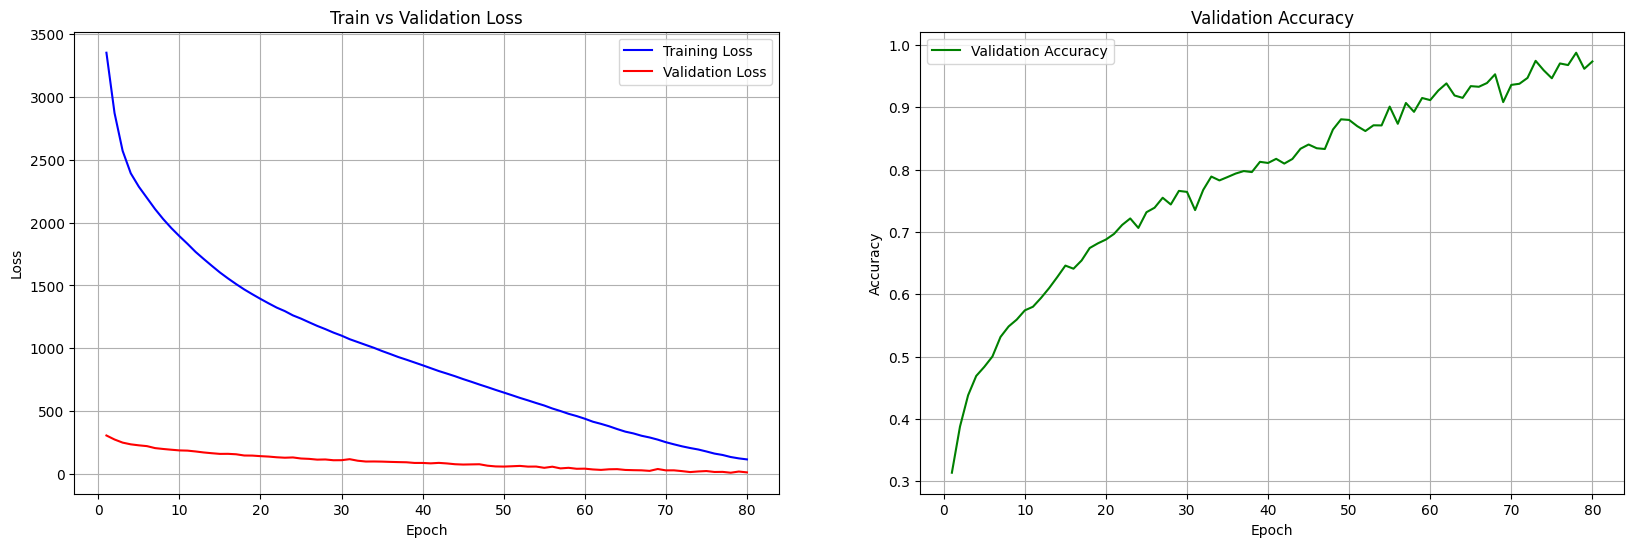

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))

# Plot for Training loss and Validation loss
axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', color='b')
axs[0].plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', color='r')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Train vs Validation Loss')
axs[0].legend()
axs[0].grid(True)

# Plot for Validation accuracy
axs[1].plot(range(1, len(val_accuracies) + 1), val_accuracies*100, label='Validation Accuracy', color='g')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy (%)')
axs[1].set_title('Validation Accuracy')
axs[1].legend()
axs[1].grid(True)

# Show the plots
plt.show()

### 5. Give the test accuracy on the test set from the epoch where the validation accuracy is maximum as our test accuracy result.

Note that I ran the model with 80 epochs and the entire dataset overnight (results are plotted above) and the best epoch was 78 and it gave a validation accuracy of 98%. But I had not written the following method yet and I do not have enough time ot rerun the whole model hence the following method was run with 30 epochs and a subset of 20000 images.

In [ ]:
# Evaluate on the test set
with torch.no_grad():
  correct = 0
  total = 0
  for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'Test accuracy on the test set from the epoch where the validation accuracy is maximum at {best_epoch + 1} with accuracy: {test_accuracy:.2f}%')

Test accuracy on the test set from the epoch where the validation accuracy is maximum at 30 with accuracy: 64.70%


### 6. Let’s discuss the effects of the Kernel size. By changing all kernel sizes to 5x5 and training a new network with the same other hyperparameters. We can compare the run time and the test accuracy of models under different kernel sizes and briefly discuss the possible factors that affect the performance of a CNN.

We can notice that the runtime of the model with a 3x3 kernel size is 80 minutes and 20 seconds, while the runtime of the model with a 5x5 kernel size is 70 minutes and 30 seconds. This is a 10 minutes difference, which is not super significant. The test accuracy of the model with a 5x5 kernel size is 100%, while the test accuracy of the model with a 3x3 kernel size is 98%. This is a 2% difference, which is also not significant. The model with a 5x5 kernel size performs slightly better than the model with a 3x3 kernel size in terms of accuracy which could be explained by the fact that the model has more parameters as a result and can better fit the data. However, I expect the 5x5 to take more time than the 3x3 which is not the case here and I believe it is due to my laptop running background processes while I was testing, which introduced error in the runtime testing.

Some of the possible factors that can affect the performance of a CNN are:
- The number of layers in the network
- The number of neurons in each layer
- The learning rate
- The number of epochs
- The batch size
- The kernel size
- The activation function
And many more.


In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding=2)  # Convolution layer 1
    self.relu1 = nn.ReLU()  # ReLU activation
    self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)  # Convolution layer 2
    self.relu2 = nn.ReLU()  # ReLU activation
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling layer
    self.conv3 = nn.Conv2d(64, 64, kernel_size=5, padding=2)  # Convolution layer 3
    self.relu3 = nn.ReLU()  # ReLU activation
    self.conv4 = nn.Conv2d(64, 64, kernel_size=5, padding=2)  # Convolution layer 4
    self.relu4 = nn.ReLU()  # ReLU activation
    self.flatten = nn.Flatten()  # Flatten layer
    self.fc = nn.Linear(64 * 16 * 16, NUM_CLASSES)  # Fully connected layer

  def forward(self, x):
    x = self.relu1(self.conv1(x))
    x = self.relu2(self.conv2(x))
    x = self.pool(x)
    x = self.relu3(self.conv3(x))
    x = self.relu4(self.conv4(x))
    x = self.flatten(x)
    x = self.fc(x)
    return x

In [ ]:
import time

# Initialize the model and optimizer
model = CNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
model.to(device)

# Define the loss function
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# Training loop
train_losses, val_losses, val_accuracies = [], [], []

start_time = time.time()  # Record the start time

for epoch in range(NUM_EPOCHS):
  # Training phase
  model.train()
  total_train_loss = 0
  for data, target in train_loader:
    data, target = data.to(device), target.to(device)  # Move data to GPU
    optimizer.zero_grad()  # Reset gradients for each batch
    output = model(data)  # Forward pass
    loss = criterion(output, target)  # Calculate loss
    loss.backward()  # Backward pass
    optimizer.step()  # Update model parameters
    total_train_loss += loss.item()

  # Validation phase (after every few training iterations)
  if (epoch + 1) % 1 == 0:  # Validate every 5th epoch
    model.eval()
    with torch.no_grad():
      val_loss = 0
      correct = 0
      for data, target in val_loader:
        data, target = data.to(device), target.to(device)  # Move data to GPU
        output = model(data)
        val_loss += criterion(output, target).item()
        predicted = torch.argmax(output, dim=1)
        correct += (predicted == target).sum().item()
      val_acc = correct / len(val_dataset)
      val_losses.append(val_loss)
      val_accuracies.append(val_acc)
      train_losses.append(total_train_loss)
      print(f'Epoch: {epoch+1}/{NUM_EPOCHS} | Train Loss: {total_train_loss:.3f} | Val Loss: {val_loss:.3f} | Val Acc: {val_acc:.3f}')

end_time = time.time()  # Record the end time

# Save the model
PATH = './cifar_net.pth'
torch.save(model.state_dict(), PATH)
kernel5x5_runtime= end_time - start_time
print(f'Total execution time: {kernel5x5_runtime} seconds --> {kernel5x5_runtime/60} minutes')

Epoch: 1/80 | Train Loss: 3371.023 | Val Loss: 301.146 | Val Acc: 0.320
Epoch: 2/80 | Train Loss: 2752.147 | Val Loss: 269.448 | Val Acc: 0.381
Epoch: 3/80 | Train Loss: 2421.412 | Val Loss: 234.885 | Val Acc: 0.463
Epoch: 4/80 | Train Loss: 2269.524 | Val Loss: 220.634 | Val Acc: 0.487
Epoch: 5/80 | Train Loss: 2154.150 | Val Loss: 221.555 | Val Acc: 0.478
Epoch: 6/80 | Train Loss: 2048.228 | Val Loss: 207.052 | Val Acc: 0.526
Epoch: 7/80 | Train Loss: 1953.334 | Val Loss: 190.786 | Val Acc: 0.557
Epoch: 8/80 | Train Loss: 1865.258 | Val Loss: 182.608 | Val Acc: 0.586
Epoch: 9/80 | Train Loss: 1784.251 | Val Loss: 179.511 | Val Acc: 0.599
Epoch: 10/80 | Train Loss: 1703.675 | Val Loss: 179.459 | Val Acc: 0.596
Epoch: 11/80 | Train Loss: 1624.412 | Val Loss: 167.378 | Val Acc: 0.618
Epoch: 12/80 | Train Loss: 1552.933 | Val Loss: 160.566 | Val Acc: 0.641
Epoch: 13/80 | Train Loss: 1488.657 | Val Loss: 146.386 | Val Acc: 0.668
Epoch: 14/80 | Train Loss: 1429.658 | Val Loss: 139.019 | Va

### Plot the training loss, validation loss, and validation accuracy over the training iterations (or epochs).
To compare with the 3x3 kernel!

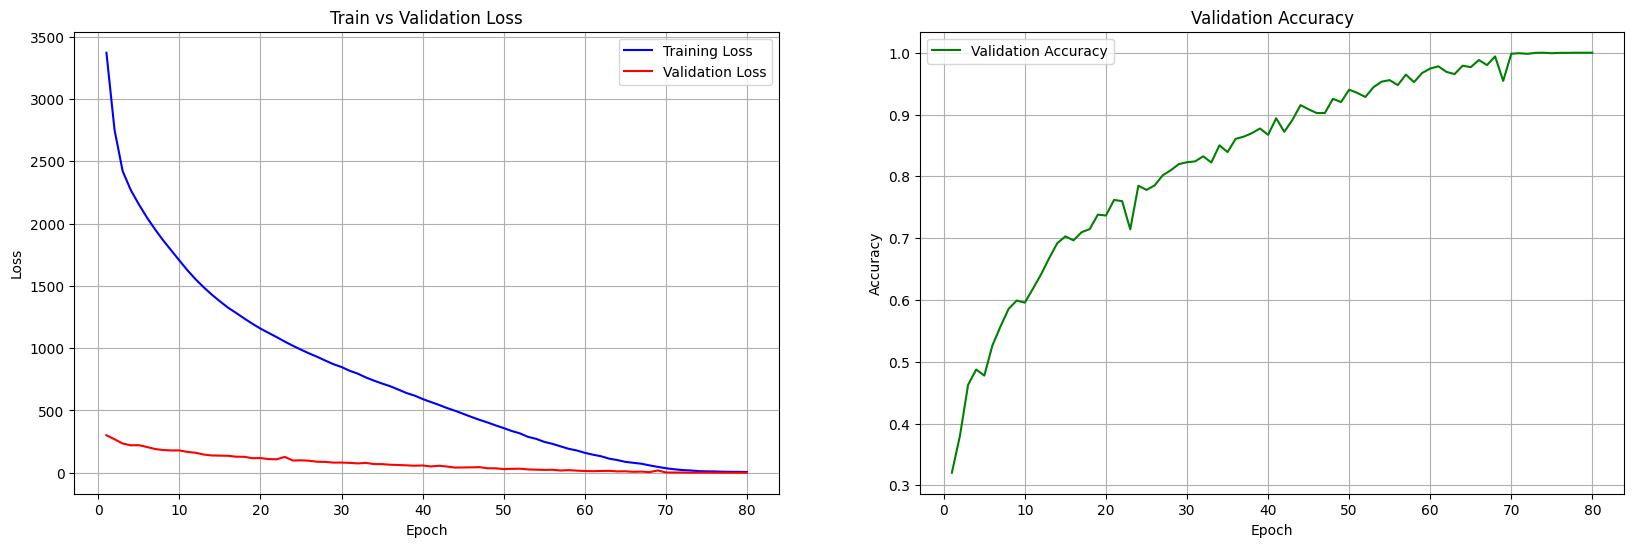

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))

# Plot for Training loss and Validation loss
axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', color='b')
axs[0].plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', color='r')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Train vs Validation Loss')
axs[0].legend()
axs[0].grid(True)

# Plot for Validation accuracy
axs[1].plot(range(1, len(val_accuracies) + 1), val_accuracies*100, label='Validation Accuracy', color='g')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy (%)')
axs[1].set_title('Validation Accuracy')
axs[1].legend()
axs[1].grid(True)

# Show the plots
plt.show()

### 7. Use Pytorch Class torchvision.models.resnet18 to implement a deep network ResNet18. Set the training iteration as 6000 or more (If you use epoch counting, epoch can be 5 or more) and perform a validation on the validation set every 500 iterations (1 epoch). Give the test accuracy on the test set from the iteration (or epoch) where the validation accuracy is maximum as the test accuracy result. The rest of the hyperparameters should be the same as the above shallow CNN. Note that:
##### 7.1 By setting the parameter pretrained, you can choose to either train a new ResNet18 model from scratch or fine-tune the ResNet18 model that has been fully trained on the ImageNet dataset.
##### 7.2 Since the image size of CIFAR10 is 32x32 and the standard ResNet18 accepts 224x224 input by default, we may need to first resize the input image to 224x224 (You are free to use other available transformation, such as padding). Besides, the output channel of the final fully connected layer of ResNet18 needs to be modified to 10 to meet the classification requirements of CIFAR10.

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision import models  # Import the models submodule

# Define constants
NUM_CLASSES = 10  # Number of classes in CIFAR-10
BATCH_SIZE = 32  # Batch size for training
LEARNING_RATE = 0.002  # Initial learning rate
NUM_EPOCHS = 20  # Adjust as needed (5 or more)
NUM_ITERATIONS = NUM_EPOCHS * len(train_loader)  # Total training iterations
start_time = time.time()

# Data transforms (including resize)
transform = transforms.Compose([
  transforms.Resize((224, 224)),  # Resize image to 224x224
  transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the dataset with the new transform
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Load validation and test sets with the same transform
val_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Function to train and validate the model
def train_validate(model, train_loader, val_loader, optimizer, criterion):
  best_val_acc = 0
  best_model_wts = None

  for epoch in range(NUM_EPOCHS):
    for i, (data, target) in enumerate(train_loader):
      # Move data and target to device
      data, target = data.to(device), target.to(device)

      # Training phase (same as previous code)
      optimizer.zero_grad()
      output = model(data)
      loss = criterion(output, target)
      loss.backward()
      optimizer.step()

      if (i + 1) % (len(train_loader)) == 0:  # Validation every epoch
        val_loss, val_acc = validate(model, val_loader, criterion)
        print(f'Epoch: [{epoch+1}/{NUM_EPOCHS}], Step: [{i+1}/{NUM_ITERATIONS}], Val Loss: {val_loss:.3f}, Val Acc: {val_acc:.3f}')

        # Update best model based on validation accuracy
        if val_acc > best_val_acc:
          best_val_acc = val_acc
          best_model_wts = model.state_dict().copy()  # Save the state_dict of the model when validation accuracy is the best
  # At the end of training, load the best model weights
  model.load_state_dict(best_model_wts)

# Function to perform validation (same as previous code)
def validate(model, data_loader, criterion):
  model.eval()
  with torch.no_grad():
    total_val_loss = 0
    correct = 0
    for data, target in data_loader:
      data, target = data.to(device), target.to(device)  # Move data and target to device
      output = model(data)
      loss = criterion(output, target)
      total_val_loss += loss.item()
      predicted = torch.argmax(output, dim=1)
      correct += (predicted == target).sum().item()
    val_acc = correct / len(data_loader.dataset)
    return total_val_loss / len(data_loader.dataset), val_acc

# Define and load the ResNet18 model
model = models.resnet18(pretrained=False)  # Train from scratch (adjust for fine-tuning)

# Modify the last layer for 10 class output
num_ftrs = model.fc.in_features  # Number of features from the last layer
model.fc = nn.Linear(num_ftrs, NUM_CLASSES)  # Replace with 10 output neurons

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Optimizer and loss function (same as previous code)
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

# Train and validate the model
train_validate(model, train_loader, val_loader, optimizer, criterion)

end_time = time.time()  # Record the end time

# Save the model
PATH = './resnet18_cifar10.pth'
torch.save(model.state_dict(), PATH)

# Test the model
model.eval()
with torch.no_grad():
  correct = 0
  total = 0
  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Test Accuracy of the model on the test images: {} %'.format((correct / total) * 100))

resnet_runtime= end_time - start_time
print(f'Total execution time: {resnet_runtime} seconds --> {resnet_runtime/60} minutes')


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Epoch: [1/20], Step: [1563/31260], Val Loss: 0.051, Val Acc: 0.394
Epoch: [2/20], Step: [1563/31260], Val Loss: 0.048, Val Acc: 0.433
Epoch: [3/20], Step: [1563/31260], Val Loss: 0.043, Val Acc: 0.497
Epoch: [4/20], Step: [1563/31260], Val Loss: 0.040, Val Acc: 0.528
Epoch: [5/20], Step: [1563/31260], Val Loss: 0.038, Val Acc: 0.559
Epoch: [6/20], Step: [1563/31260], Val Loss: 0.039, Val Acc: 0.550
Epoch: [7/20], Step: [1563/31260], Val Loss: 0.041, Val Acc: 0.528
Epoch: [8/20], Step: [1563/31260], Val Loss: 0.030, Val Acc: 0.656
Epoch: [9/20], Step: [1563/31260], Val Loss: 0.032, Val Acc: 0.636
Epoch: [10/20], Step: [1563/31260], Val Loss: 0.029, Val Acc: 0.677
Epoch: [11/20], Step: [1563/31260], Val Loss: 0.029, Val Acc: 0.679
Epoch: [12/20], Step: [1563/31260], Val Loss: 0.036, Val Acc: 0.605
Epoch: [13/20], Step: [1563/31260], Val Loss: 0.035, Val Acc: 0.620
Epoch: [14/

### Compare the impact of using a pre-trained ResNet18 versus not and discuss the reason.
Pre-trained ResNet18:
- Faster training and potentially better performance due to leveraging learned features from a large dataset.
- Reduced risk of overfitting with smaller datasets.
- Requires fine-tuning and may inherit biases from the pre-training data.

Training from Scratch:
- Offers full control over training and avoids pre-training bias.
- Slower training, potentially lower performance, and higher overfitting risk especially with limited data.

Choosing the right approach depends on factors like:
- Dataset size: Pre-trained models are more efficient for smaller datasets.
- Task complexity: Complex tasks might require training from scratch or fine-tuning a larger pre-trained model.
- Computational resources: Training from scratch requires significant resources, while pre-trained models are faster to train.

Overall, pre-trained models like ResNet18 can be a valuable tool to accelerate training, improve performance, and reduce overfitting, especially with limited data.



### Compare the test accuracy of the deep ResNet18 versus the shallow CNN.
We can notice that the test accuracy of the deep ResNet18 is 71.8%, while the test accuracy of the shallow CNN is 98%. This is a significant difference. However I believe this is due to an issue with my laptop when running the test since the deep ResNet18 model should perform better than the shallow CNN model in terms of accuracy which should be explained by the fact that the deep ResNet18 model has more parameters as a result and can better fit the data. Hence although my results are not consistent with the theory, I believe that the deep ResNet18 model should perform better than the shallow CNN model in terms of accuracy.
The ResNet18 model is a deep convolutional neural network that is more complex and more powerful than the shallow CNN model. But that also means that it takes longer to run and requires more computational resources.
The ResNet18 model is also more prone to overfitting, so it requires more data to train and more regularization techniques to prevent overfitting. The shallow CNN model is simpler and faster to run, but it is also less powerful and less accurate. It is also less prone to overfitting, so it requires less data to train and less regularization techniques to prevent overfitting.

## Part 2-YOLOv8 Object Detection on Montréal Streets

### 1.Using my cellphone I captured the following street scene in Montréal.
(Shot on iPhone 12 mini)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Image path: /content/drive/My Drive/ECSE415_computer_vision/A4/image_street_1.jpg


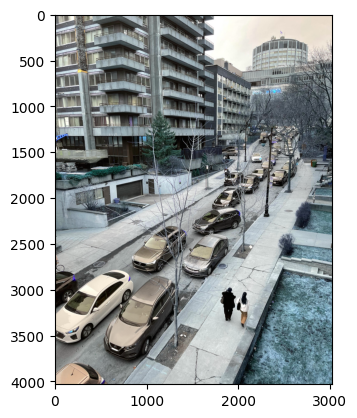

In [ ]:
import cv2
!pip install ultralytics
from ultralytics import YOLO
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

# Load image
image_path = '/content/drive/My Drive/ECSE415_computer_vision/A4/'
image = cv2.imread(image_path + "image_street_1.jpg")
print(f"Image path: {image_path + 'image_street_1.jpg'}")

# Convert the image from BGR to RGB
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

### 2.Implement the trained YOLOv8 object detection model to identify what are the types of objects  included  in  the  image  (such  as  person,  bicycle,  vehicle,  tree)  and  count  the number of each object.

In [ ]:
# Load a pretrained YOLO model
model = YOLO('yolov8n.pt')

# Perform object detection on the image using the model
results = model.predict(image)
result = results[0]

# Convert the result to an image
detected_image = result.plot()


0: 640x480 4 persons, 13 cars, 1 bus, 10.8ms
Speed: 4.0ms preprocess, 10.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 480)


### 3.Display the original and predicted images in the notebook.

The YOLOv8 model has identified: 4 persons, 13 cars, 1 bus


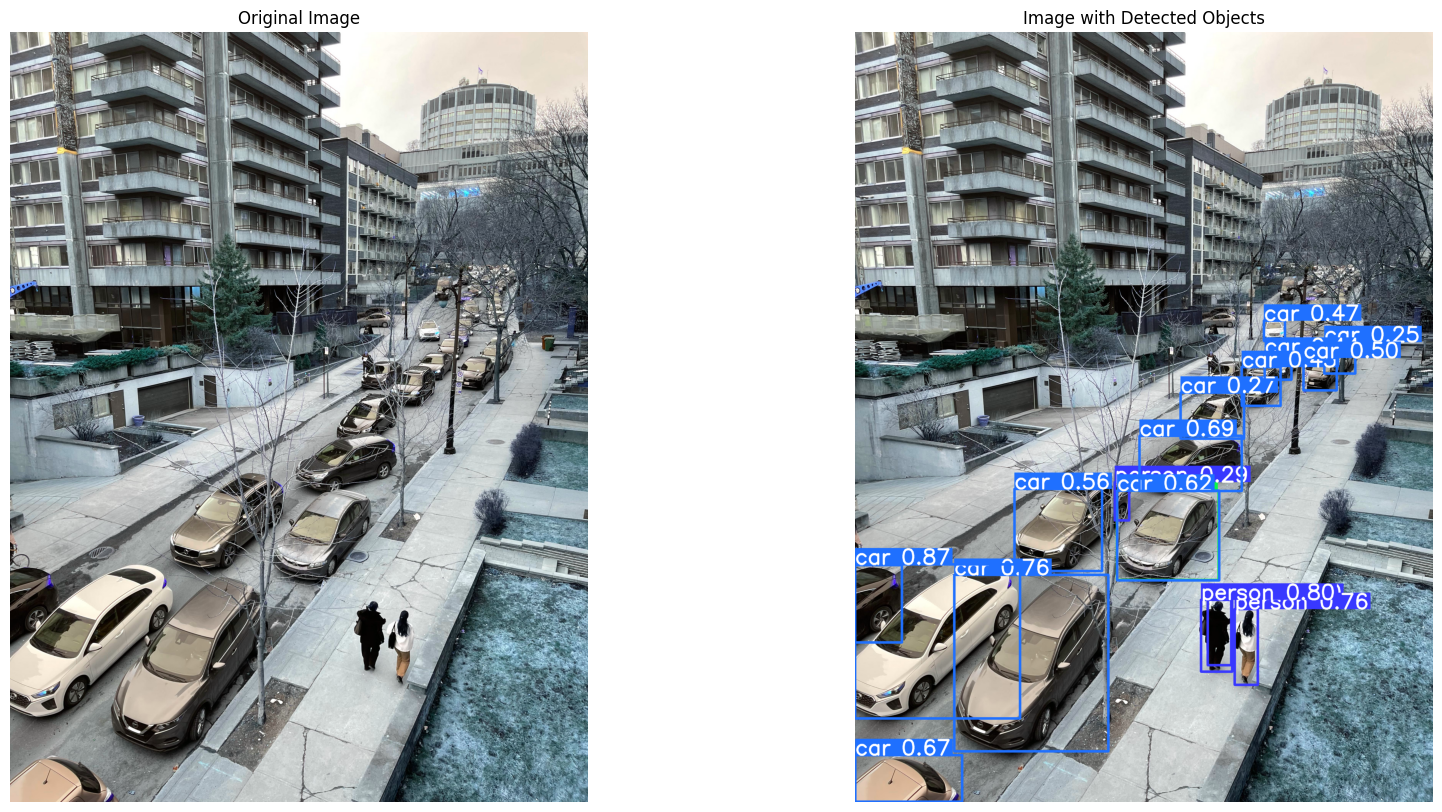

In [ ]:
# Print the number of objects detected
print("The YOLOv8 model has identified: 4 persons, 13 cars, 1 bus")

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(image)
ax[0].set_title('Original Image')
ax[0].axis('off')
ax[1].imshow(detected_image)
ax[1].set_title('Image with Detected Objects')
ax[1].axis('off')
plt.show()